# Chapitre 6 Appliquer le Machine Learning à la finance

## 1. Comprendre l’application du Machine Learning en finance
Découvrir comment le Machine Learning est utilisé dans la finance : prédiction des prix, classification des tendances et optimisation des stratégies d’investissement.

## 2. Préparer les données pour un modèle ML 

In [1]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import ta  # pip install ta

# Charger les données Apple (AAPL)
data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
# Ça fonctionne même si yfinance renvoie un DataFrame multi-niveaux
data.columns = data.columns.droplevel('Ticker')
data = data.dropna()

# Ajouter des indicateurs techniques
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['RSI'] = ta.momentum.RSIIndicator(data['Close']).rsi()

# Créer la variable cible (ex: hausse du prix demain)
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)

data.dropna(inplace=True)
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,SMA_20,RSI,Target
Date,,,,,,,,
2020-01-30,78.410362,78.463626,77.170789,77.604158,126743200,75.545422,66.350188,0
2020-01-31,74.933754,78.122266,74.638386,77.698583,199588400,75.656307,48.053164,0
2020-02-03,74.727959,75.897320,73.168805,73.672379,173788400,75.792249,47.223014,1
2020-02-04,77.195000,77.386264,75.931214,76.337948,136616400,76.022853,56.847290,1
2020-02-05,77.824463,78.625828,77.219202,78.325613,118826800,76.301999,58.906386,1


## 3. Construire un modèle de classification pour le trading

Dans cette section, nous allons construire un **modèle de classification** pour prédire des signaux d’achat ou de vente à partir de données boursières.

### Objectif

Le but est d’apprendre à une machine à **classer chaque jour boursier** en deux catégories :
- **1 = Achat** : le prix a de fortes chances d’augmenter demain.
- **0 = Vente ou Ne rien faire** : le prix risque de baisser ou de stagner.

Ce type de modèle est utilisé dans des stratégies dites **discrétionnaires automatisées**, où chaque prédiction devient un **signal de trading**.

### Exemple

Nous allons utiliser des **indicateurs techniques** comme :
- La moyenne mobile (SMA)
- Le RSI (Relative Strength Index)

Ces indicateurs serviront de **features** (variables explicatives) pour notre modèle.

Ensuite, on utilisera un **classificateur de type Random Forest** (ou SVM, KNN, etc.) pour :
- **Apprendre à partir de données historiques**
- **Générer un signal binaire : acheter ou non**

###  Étapes à suivre :
1. Séparer les données en **variables explicatives (features)** et **cible (target)**.
2. Diviser le dataset en **jeu d’entraînement** et **jeu de test**.
3. Entraîner un modèle de classification.
4. Évaluer la **précision des prédictions** à l’aide de métriques comme `accuracy`, `precision`, `recall`, `f1-score`.

Ce modèle sera plus tard intégré dans une **stratégie de trading automatisée** que nous pourrons simuler.



In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Features & target
features = ['SMA_20', 'RSI']
X = data[features]
y = data['Target']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Modèle
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.79      0.55       106
           1       0.55      0.19      0.28       142

    accuracy                           0.45       248
   macro avg       0.49      0.49      0.42       248
weighted avg       0.50      0.45      0.40       248



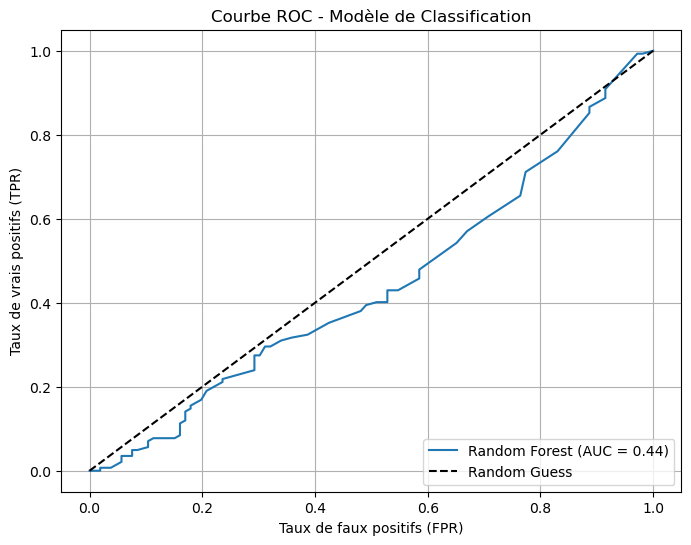

In [4]:

# Prédictions probabilistes
y_prob = clf.predict_proba(X_test)[:, 1]

# Calcul ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Affichage courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Modèle de Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Classification Report :
              precision    recall  f1-score   support

           0       0.41      0.64      0.50       106
           1       0.54      0.31      0.39       142

    accuracy                           0.45       248
   macro avg       0.47      0.48      0.45       248
weighted avg       0.48      0.45      0.44       248



/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


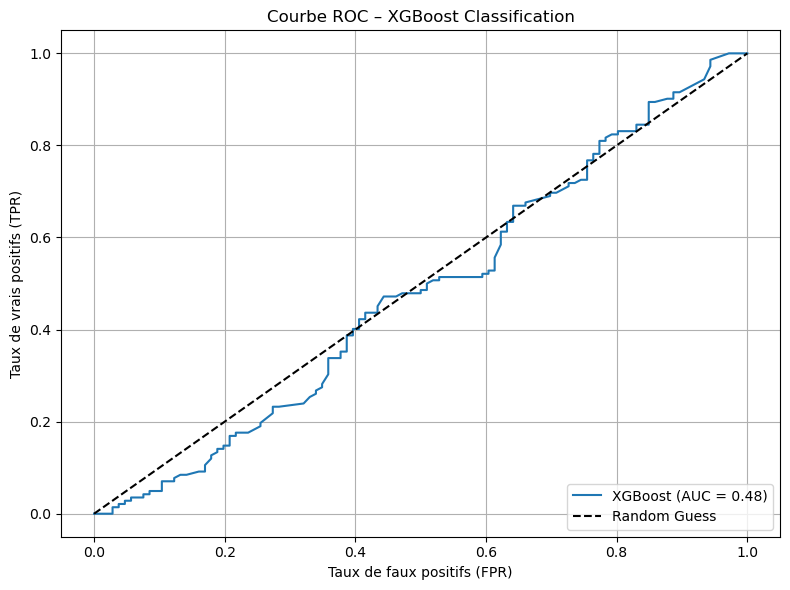

In [5]:
#Autre modèle

# Étape 1 : Installer la bibliothèque si ce n'est pas déjà fait
# pip install xgboost

# Étape 2 : Importer XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Étape 3 : Définir les features et la cible
features = ['SMA_20', 'RSI']
X = data[features]
y = data['Target']

# Étape 4 : Diviser en jeu d'entraînement et de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Étape 5 : Entraîner le modèle XGBoost (classification)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Étape 6 : Évaluer les performances
y_pred = model.predict(X_test)
print("Classification Report :")
print(classification_report(y_test, y_pred))

# Étape 7 : Courbe ROC + AUC
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC – XGBoost Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## 4. Construire un modèle de régression pour prévoir les prix

Dans cette section, nous allons construire un modèle de régression pour estimer les prix futurs d'une action à partir des données historiques.

### Objectif

Contrairement à un modèle de classification, qui prédit une classe (par exemple "achat" ou "vente"), un modèle de régression permet de prédire une valeur numérique continue. Dans le cadre de ce projet, nous chercherons à estimer le prix de clôture du lendemain à partir des indicateurs techniques calculés aujourd’hui.

L’objectif est d’anticiper les variations futures du marché afin de prendre des décisions d’investissement éclairées.

### Exemple de cas d’usage

Si le modèle prédit que le prix de l’action Apple sera de 145.30 dollars demain, alors qu’il est aujourd’hui à 140.00 dollars, cela peut indiquer une opportunité d’achat. Inversement, une baisse anticipée du prix peut justifier une décision de vente.

### Modèles de régression possibles

Voici quelques modèles fréquemment utilisés pour ce type de tâche :

- Régression linéaire
- Lasso et Ridge (régularisés)
- Random Forest Regressor
- Gradient Boosting Regressor (XGBoost, LightGBM, etc.)

Nous utiliserons ici le modèle Random Forest Regressor, bien adapté aux relations complexes et non linéaires dans les données financières.

### Étapes à suivre

1. Créer la variable cible en décalant le prix de clôture d’un jour : `Close_tomorrow = Close.shift(-1)`
2. Sélectionner les indicateurs techniques comme variables explicatives (features)
3. Diviser les données en jeu d’entraînement et de test
4. Entraîner le modèle de régression
5. Évaluer la qualité des prédictions à l’aide de métriques appropriées :
   - RMSE (Root Mean Squared Error) : mesure l’erreur quadratique moyenne
   - MAE (Mean Absolute Error) : moyenne des écarts absolus
   - R² (coefficient de détermination) : proportion de la variance expliquée par le modèle

### Remarques

Un bon modèle de régression ne garantit pas une bonne stratégie de trading. Il est essentiel de :
- Vérifier la stabilité du modèle dans le temps
- Intégrer les prédictions dans une stratégie d’investissement testée sur le long terme
- Comparer les performances à des approches plus simples (moyenne mobile, Buy & Hold, etc.)

L’intégration d’un modèle de régression dans une stratégie de trading fera l’objet de la prochaine section.


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prédire le prix de clôture du lendemain
data['Close_tomorrow'] = data['Close'].shift(-1)
data.dropna(inplace=True)

X = data[features]
y = data['Close_tomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²:", r2_score(y_test, y_pred))

RMSE: 29.697286305721427
R²: -0.34994514513969577


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


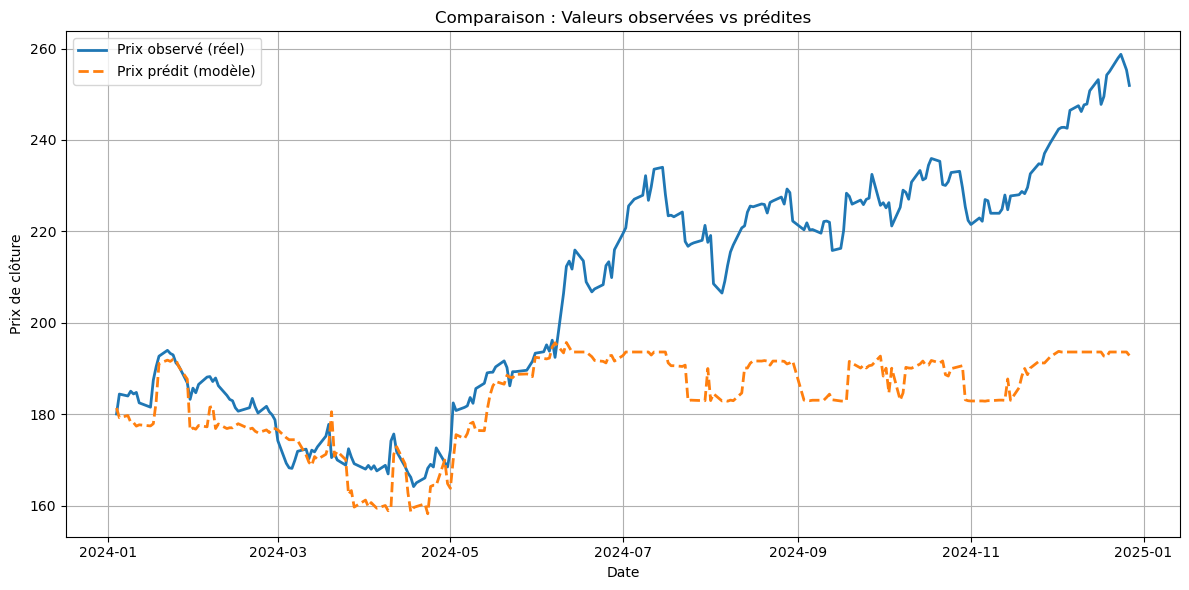

In [7]:

# Visualisation : valeurs observées vs prédites
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label="Prix observé (réel)", linewidth=2)
plt.plot(y_test.index, y_pred, label="Prix prédit (modèle)", linestyle='--', linewidth=2)
plt.title("Comparaison : Valeurs observées vs prédites")
plt.xlabel("Date")
plt.ylabel("Prix de clôture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Tester les performances des modèles ML

## Évaluation des performances des modèles

Une fois les modèles entraînés (classification ou régression), il est essentiel d’évaluer leur performance à l’aide de métriques adaptées. Voici un tableau récapitulatif des principales métriques utilisées :

| **Métrique**           | **Type de modèle** | **Interprétation** |
|------------------------|--------------------|---------------------|
| **Accuracy**           | Classification     | Proportion de prédictions correctes. Peut être trompeuse si les classes sont déséquilibrées. |
| **Precision**          | Classification     | Parmi les prédictions positives, combien sont correctes ? Mesure la qualité des prédictions positives. |
| **Recall**             | Classification     | Parmi les vraies valeurs positives, combien ont été correctement prédites ? Utile pour ne pas rater les cas importants. |
| **F1-score**           | Classification     | Moyenne harmonique entre précision et rappel. Bon compromis lorsque les classes sont déséquilibrées. |
| **AUC (ROC)**          | Classification     | Surface sous la courbe ROC. Mesure la capacité du modèle à distinguer les classes. 1 = parfait, 0.5 = aléatoire. |
| **RMSE**               | Régression         | Racine de l’erreur quadratique moyenne. Plus la valeur est basse, meilleure est la prédiction. |
| **MAE**                | Régression         | Moyenne des erreurs absolues. Représente l’erreur moyenne en valeur absolue. |
| **R² (coefficient de détermination)** | Régression | Proportion de la variance expliquée par le modèle. 1 = parfait, 0 = aucune explication. Une valeur négative signifie que le modèle est pire que la moyenne. |

### Exemple d’interprétation

**Pour un modèle de classification :**
- Accuracy = 0.87 : le modèle fait 87 % de bonnes prédictions
- F1-score = 0.75 : bon équilibre entre faux positifs et faux négatifs
- AUC = 0.92 : excellente capacité à distinguer les classes (achat/vente)

**Pour un modèle de régression :**
- RMSE = 1.65 : le modèle se trompe en moyenne de 1.65 unités de prix
- MAE = 1.20 : l'erreur absolue moyenne est de 1.20
- R² = 0.81 : 81 % de la variance des prix est expliquée par le modèle

L’analyse de ces indicateurs permet de juger la pertinence du modèle et d’identifier les pistes d’amélioration (meilleures features, réglage des hyperparamètres, etc.).


## 6. Intégrer le modèle ML dans une stratégie de trading

Jusqu’ici, nous avons entraîné des modèles de Machine Learning pour prédire des signaux (achat/vente) ou des prix futurs. Cependant, une prédiction seule n’a pas de valeur si elle n’est pas **intégrée dans une stratégie concrète de prise de décision**. Cette section consiste à transformer les résultats du modèle en **actions exploitables sur les marchés**.

### Objectif

Utiliser les prédictions du modèle pour générer des **signaux de trading automatiques**, puis simuler une stratégie d’investissement basée sur ces signaux. Cela permet de tester si le modèle aurait permis de réaliser un profit, comparé à une stratégie de base comme le **Buy & Hold**.

### Principe de fonctionnement

1. **Générer les signaux :** à partir des prédictions du modèle (classification), on crée une colonne "Signal" qui indique quoi faire :
   - `1` → acheter (anticipation de hausse)
   - `0` → ne rien faire ou vendre (anticipation de baisse)

2. **Calculer les rendements :**
   - `Returns` : les rendements quotidiens réels du marché (basés sur le prix de clôture)
   - `Strategy_Returns` : rendements générés par la stratégie basée sur les signaux du modèle

3. **Comparer les performances :**
   - Simuler les deux stratégies dans le temps :
     - Buy & Hold : investir au début et ne rien faire jusqu’à la fin
     - ML Strategy : acheter uniquement lorsque le modèle le recommande
   - Visualiser les **performances cumulées** dans un graphique

### Avantages de cette approche

- Permet de **valider la valeur réelle** du modèle dans un contexte d’investissement
- Met en évidence les cas où le modèle aurait **généré un gain ou une perte**
- Sert de base à une **optimisation future** (filtrage des signaux, stop loss, take profit, etc.)

### Limites

- Ce backtest ne prend pas encore en compte les **frais de transaction, glissements, ou volumes disponibles**, qui peuvent impacter fortement les performances réelles
- Il s’agit d’une simulation sur le passé : une bonne performance historique ne garantit pas des résultats futurs

L’intégration de ces signaux dans une **stratégie de trading robuste et testée** est une étape clé vers l’automatisation et l’application réelle du Machine Learning en finance.


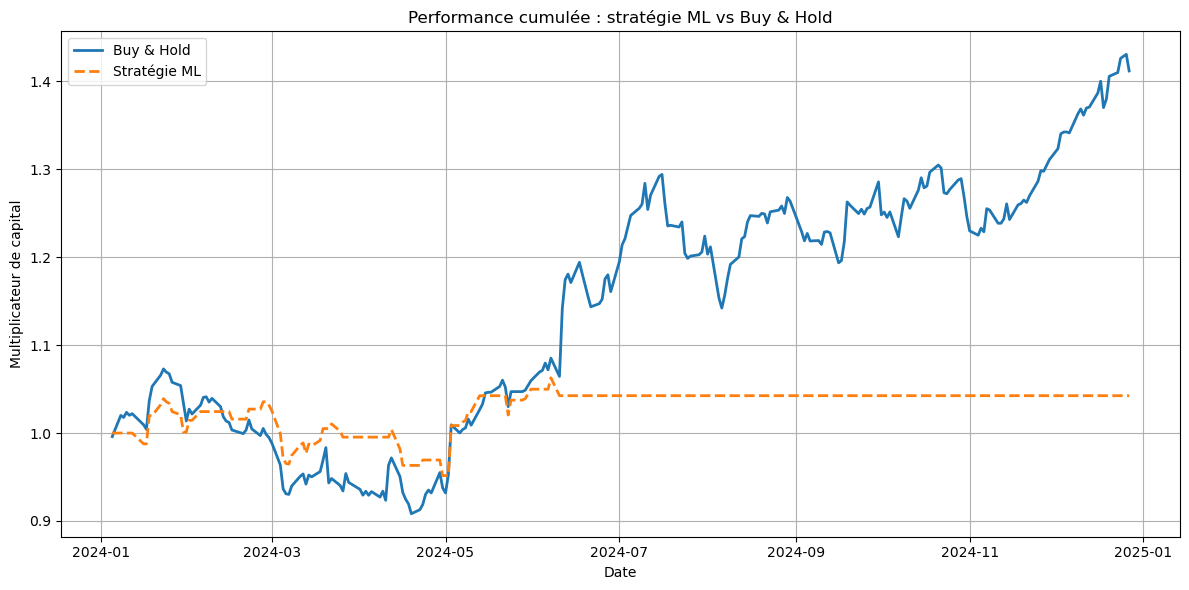

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Étape 1 : Générer les signaux de trading à partir des prédictions du modèle de classification
# On utilise les prédictions sur le jeu de test
data_test = data.iloc[-len(y_test):].copy()  # copie alignée avec X_test
data_test['Signal'] = clf.predict(X_test)

# Étape 2 : Calculer les rendements du marché
# Rendement quotidien : variation relative du prix de clôture
data_test['Returns'] = data_test['Close'].pct_change()

# Rendement de la stratégie basée sur les signaux
# On applique le signal de la veille au rendement du jour
data_test['Strategy_Returns'] = data_test['Returns'] * data_test['Signal'].shift(1)

# Étape 3 : Performance cumulée
data_test['Cumulative_Market'] = (1 + data_test['Returns']).cumprod()
data_test['Cumulative_Strategy'] = (1 + data_test['Strategy_Returns']).cumprod()

# Étape 4 : Visualisation
plt.figure(figsize=(12, 6))
plt.plot(data_test.index, data_test['Cumulative_Market'], label='Buy & Hold', linewidth=2)
plt.plot(data_test.index, data_test['Cumulative_Strategy'], label='Stratégie ML', linewidth=2, linestyle='--')
plt.title('Performance cumulée : stratégie ML vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Multiplicateur de capital')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
